
# **Setup & Reproducibility**

In [38]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import time
from collections import Counter, defaultdict
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import sys

# Set seed for reproducibility
SEED = 42

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Enable deterministic behavior
cudnn.deterministic = True
cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Environment summary
print("Environment Summary:")
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")
print(f"Seed: {SEED}")
print(f"cuDNN deterministic: {cudnn.deterministic}")
print(f"cuDNN benchmark: {cudnn.benchmark}")

Environment Summary:
Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
Device: cuda
Seed: 42
cuDNN deterministic: True
cuDNN benchmark: False


# **1) Model Architecture**
**1.1 Base Model Selection**

In [39]:
# Load ResNet18 with pretrained weights (better initialization)
model = models.resnet18(pretrained=True)
print(f"Using resnet18, pretrained=True")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using resnet18, pretrained=True
Total parameters: 11,689,512
Trainable parameters: 11,689,512


**1.2 Activation Function Replacement**

In [40]:
def count_and_replace_relu(model, replace_from_idx=6, new_activation_class=nn.SiLU):
    """
    Count ReLU modules and replace from the specified index onward
    """
    relu_modules = []

    # Find all ReLU modules
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            relu_modules.append((name, module))

    print(f"Total nn.ReLU count before replacement: {len(relu_modules)}")

    # If there are fewer ReLUs than the starting index, don't replace any
    if len(relu_modules) <= replace_from_idx:
        print(f"No replacements needed: only {len(relu_modules)} ReLU modules found")
        return model

    # Replace from the specified index onward
    replaced_indices = []
    for i, (name, module) in enumerate(relu_modules):
        if i >= replace_from_idx:  # 0-based index
            # Get parent module and child name
            parent_name = name.rsplit('.', 1)[0] if '.' in name else ''
            child_name = name.rsplit('.', 1)[1] if '.' in name else name

            # Create a new instance of the activation for each replacement
            new_activation = new_activation_class()

            if parent_name:
                parent = dict(model.named_modules())[parent_name]
                setattr(parent, child_name, new_activation)
                replaced_indices.append(i)
            else:
                # This is the root module (shouldn't happen with ResNet)
                model.add_module(child_name, new_activation)
                replaced_indices.append(i)

    print(f"Replaced activations at 0-based indices: {replaced_indices}")
    print(f"Replaced activations at 1-based indices: {[i+1 for i in replaced_indices]}")

    # Count remaining ReLUs
    remaining_relus = 0
    new_activations = 0
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            remaining_relus += 1
        if isinstance(module, new_activation_class):
            new_activations += 1

    print(f"ReLU remaining: {remaining_relus}")
    print(f"{new_activation_class.__name__} inserted: {new_activations}")

    # Assertion
    expected_remaining = min(replace_from_idx, len(relu_modules))
    expected_new = max(0, len(relu_modules) - replace_from_idx)

    assert remaining_relus == expected_remaining, f"Expected {expected_remaining} remaining ReLUs, got {remaining_relus}"
    assert new_activations == expected_new, \
        f"Expected {expected_new} new activations, got {new_activations}"

    return model

# First check how many ReLU modules we have
relu_count = 0
for name, module in model.named_modules():
    if isinstance(module, nn.ReLU):
        relu_count += 1

print(f"Found {relu_count} ReLU modules in the model")

# Replace ReLU from the appropriate index
if relu_count > 6:
    model = count_and_replace_relu(model, replace_from_idx=6, new_activation_class=nn.SiLU)
else:
    print(f"Model has only {relu_count} ReLU modules, replacing from index {max(0, relu_count-3)}")
    model = count_and_replace_relu(model, replace_from_idx=max(0, relu_count-3), new_activation_class=nn.SiLU)

Found 9 ReLU modules in the model
Total nn.ReLU count before replacement: 9
Replaced activations at 0-based indices: [6, 7, 8]
Replaced activations at 1-based indices: [7, 8, 9]
ReLU remaining: 6
SiLU inserted: 3


**1.3 Classification Head Modification**

In [41]:
# Get the number of input features for the final layer
in_features = model.fc.in_features
print(f"Old head shape: in_features={in_features} → out_features=1000")

# Replace with new head for 3 classes
num_classes = 3
model.fc = nn.Linear(in_features, num_classes)
print(f"New head shape: in_features={in_features} → out_features={num_classes}")
print(f"Number of target classes: {num_classes}")

# Move model to device
model = model.to(device)

Old head shape: in_features=512 → out_features=1000
New head shape: in_features=512 → out_features=3
Number of target classes: 3


# **2) Data Pipeline**
**2.1 Dataset Preparation**

In [42]:
# Define selected classes
selected_classes = ['cat', 'dog', 'airplane']
print(f"Selected classes: {selected_classes}")

# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Create mapping from class name to CIFAR-10 label
class_to_original_label = {cls: cifar10_classes.index(cls) for cls in selected_classes}
print(f"Original label mapping: {class_to_original_label}")

# Create mapping from original label to new label
original_to_new_label = {original: new for new, original in enumerate(class_to_original_label.values())}
print(f"New label mapping: {original_to_new_label}")

# Create mapping from class name to new label
class_to_new_label = {cls: new for new, cls in enumerate(selected_classes)}
print(f"Class to new label mapping: {class_to_new_label}")

Selected classes: ['cat', 'dog', 'airplane']
Original label mapping: {'cat': 3, 'dog': 5, 'airplane': 0}
New label mapping: {3: 0, 5: 1, 0: 2}
Class to new label mapping: {'cat': 0, 'dog': 1, 'airplane': 2}


In [43]:
def filter_cifar10_dataset(dataset, selected_classes, class_to_original_label, original_to_new_label):
    """
    Filter CIFAR-10 dataset to only include selected classes and relabel them
    """
    # Get indices of samples that belong to selected classes
    selected_indices = []
    for idx, (_, label) in enumerate(dataset):
        if label in class_to_original_label.values():
            selected_indices.append(idx)

    # Create subset with only selected classes
    filtered_dataset = Subset(dataset, selected_indices)

    # Create a modified dataset that returns relabeled samples
    class FilteredRelabeledDataset(torch.utils.data.Dataset):
        def __init__(self, subset, original_to_new_label):
            self.subset = subset
            self.original_to_new_label = original_to_new_label

        def __getitem__(self, idx):
            image, label = self.subset[idx]
            new_label = self.original_to_new_label[label]
            return image, new_label

        def __len__(self):
            return len(self.subset)

    return FilteredRelabeledDataset(filtered_dataset, original_to_new_label)

# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)

# Filter and relabel datasets
filtered_train_dataset = filter_cifar10_dataset(
    train_dataset, selected_classes, class_to_original_label, original_to_new_label)
filtered_test_dataset = filter_cifar10_dataset(
    test_dataset, selected_classes, class_to_original_label, original_to_new_label)

# Count samples per class
def count_classes(dataset):
    counts = Counter()
    for _, label in dataset:
        counts[label] += 1
    return counts

train_counts = count_classes(filtered_train_dataset)
test_counts = count_classes(filtered_test_dataset)

print("Training set counts:")
for label, count in train_counts.items():
    print(f"  Class {label} ({selected_classes[label]}): {count} samples")

print("Test set counts:")
for label, count in test_counts.items():
    print(f"  Class {label} ({selected_classes[label]}): {count} samples")



Training set counts:
  Class 0 (cat): 5000 samples
  Class 1 (dog): 5000 samples
  Class 2 (airplane): 5000 samples
Test set counts:
  Class 0 (cat): 1000 samples
  Class 2 (airplane): 1000 samples
  Class 1 (dog): 1000 samples


**2.2 Data Augmentation**

In [44]:
# Define transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Apply transforms to datasets
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

# Create transformed datasets
train_dataset = TransformedDataset(filtered_train_dataset, train_transform)
test_dataset = TransformedDataset(filtered_test_dataset, test_transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Print transform summaries
print("Train transforms: RandomCrop(32, padding=4), RandomHorizontalFlip, ToTensor, Normalize")
print("Test transforms: ToTensor, Normalize")

# Sample batch
sample_images, sample_labels = next(iter(train_loader))
print(f"Train batch shape: {sample_images.shape}")
print(f"Train labels shape: {sample_labels.shape}")

sample_images, sample_labels = next(iter(test_loader))
print(f"Test batch shape: {sample_images.shape}")
print(f"Test labels shape: {sample_labels.shape}")

Train transforms: RandomCrop(32, padding=4), RandomHorizontalFlip, ToTensor, Normalize
Test transforms: ToTensor, Normalize
Train batch shape: torch.Size([64, 3, 32, 32])
Train labels shape: torch.Size([64])
Test batch shape: torch.Size([64, 3, 32, 32])
Test labels shape: torch.Size([64])


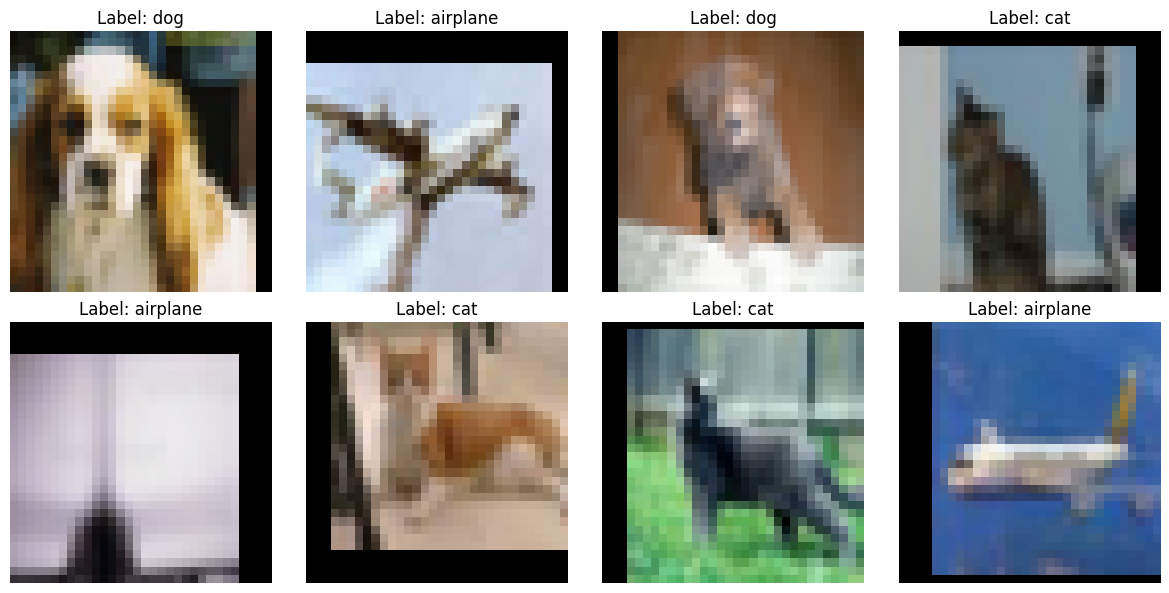

In [45]:
# Display sample augmented images
def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = std * img + mean  # Reverse the normalization
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    return img

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i], title=f'Label: {selected_classes[labels[i].item()]}')
plt.tight_layout()
plt.show()

# **3) Training & Evaluation**
**3.1 Training Loop**

In [46]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    return train_loss, train_acc

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total

    return test_loss, test_acc

# Training loop
num_epochs = 10
best_acc = 0
best_epoch = 0

train_losses, train_accs = [], []
test_losses, test_accs = [], []

start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

    # Update scheduler
    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Check for best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch + 1

    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {test_loss:.4f} | Val Acc: {test_acc:.2f}%')

training_time = time.time() - start_time
print(f'Best Val Acc: {best_acc:.2f}% (epoch {best_epoch})')
print(f'Total training time: {training_time/60:.2f} minutes')

Epoch 1/10 | Train Loss: 0.5351 | Train Acc: 76.84% | Val Loss: 0.4541 | Val Acc: 81.13%
Epoch 2/10 | Train Loss: 0.4229 | Train Acc: 81.48% | Val Loss: 0.4510 | Val Acc: 81.40%
Epoch 3/10 | Train Loss: 0.3796 | Train Acc: 83.63% | Val Loss: 0.3670 | Val Acc: 84.40%
Epoch 4/10 | Train Loss: 0.3673 | Train Acc: 84.65% | Val Loss: 0.4108 | Val Acc: 82.13%
Epoch 5/10 | Train Loss: 0.3502 | Train Acc: 85.59% | Val Loss: 0.3498 | Val Acc: 84.73%
Epoch 6/10 | Train Loss: 0.3454 | Train Acc: 85.23% | Val Loss: 0.3491 | Val Acc: 85.47%
Epoch 7/10 | Train Loss: 0.3228 | Train Acc: 86.31% | Val Loss: 0.3462 | Val Acc: 85.13%
Epoch 8/10 | Train Loss: 0.2712 | Train Acc: 88.73% | Val Loss: 0.3075 | Val Acc: 87.60%
Epoch 9/10 | Train Loss: 0.2403 | Train Acc: 90.17% | Val Loss: 0.2916 | Val Acc: 87.77%
Epoch 10/10 | Train Loss: 0.2279 | Train Acc: 90.42% | Val Loss: 0.2922 | Val Acc: 88.00%
Best Val Acc: 88.00% (epoch 10)
Total training time: 2.58 minutes


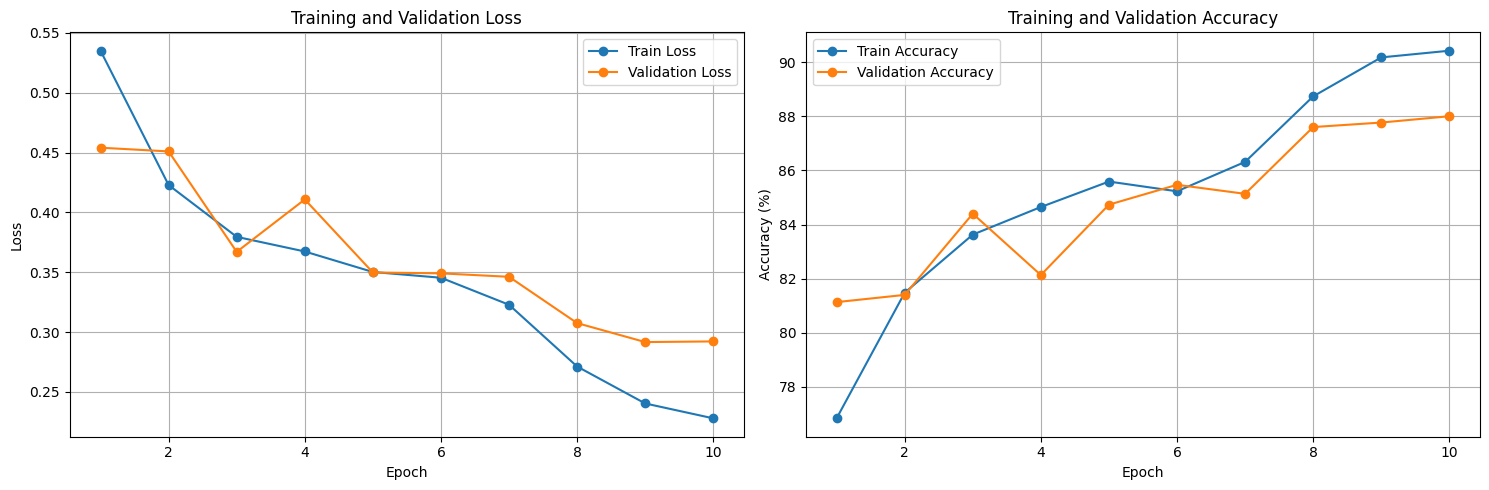


Final Training Accuracy: 90.42%
Final Validation Accuracy: 88.00%
Best Validation Accuracy: 88.00% (epoch 10)


In [50]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, num_epochs+1), test_losses, label='Validation Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy', marker='o')
ax2.plot(range(1, num_epochs+1), test_accs, label='Validation Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {test_accs[-1]:.2f}%")
print(f"Best Validation Accuracy: {best_acc:.2f}% (epoch {best_epoch})")


**3.2 Performance Reporting**

Final Val Accuracy: 88.00%


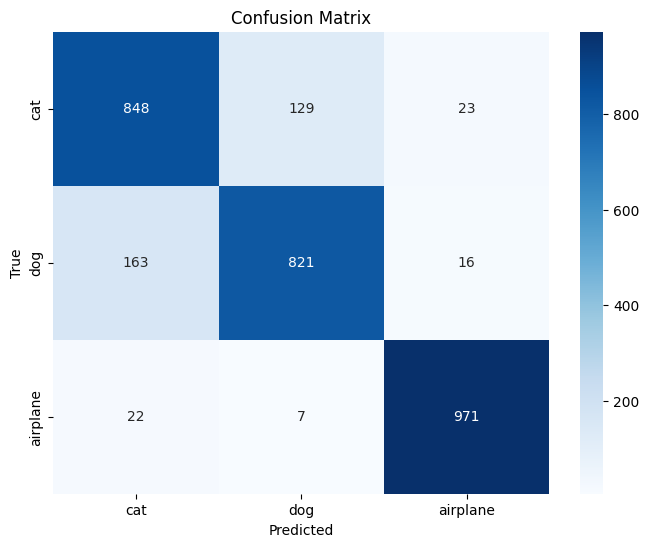

Classification Report:
              precision    recall  f1-score   support

         cat       0.82      0.85      0.83      1000
         dog       0.86      0.82      0.84      1000
    airplane       0.96      0.97      0.97      1000

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



In [47]:
# Final evaluation
final_test_loss, final_test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Final Val Accuracy: {final_test_acc:.2f}%")

# Confusion matrix
def get_predictions(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_preds

true_labels, predictions = get_predictions(model, test_loader, device)

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=selected_classes,
            yticklabels=selected_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=selected_classes))

**3.3 Testing**

Testing examples:


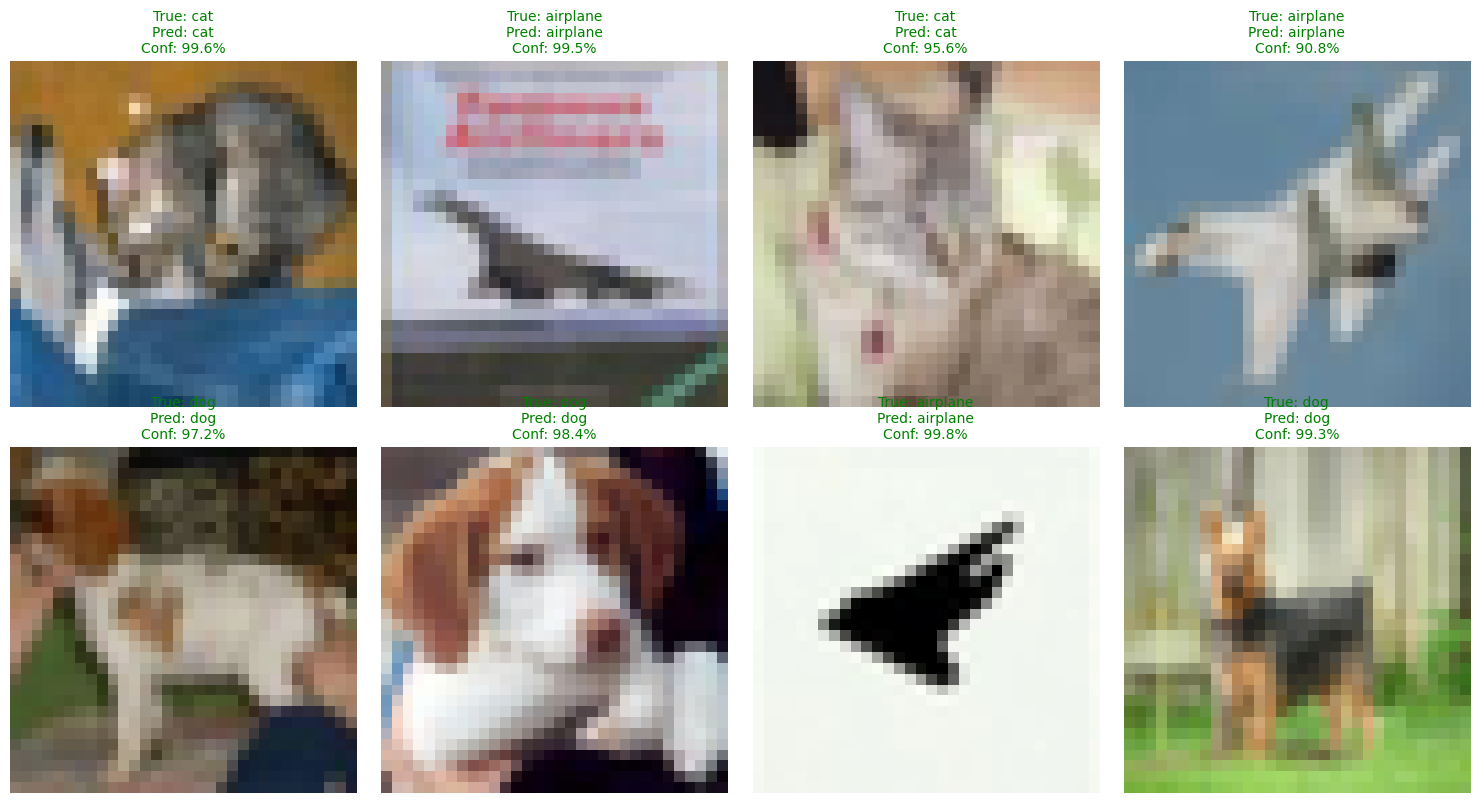

Overall Test Accuracy: 88.00%

Confidence distribution:


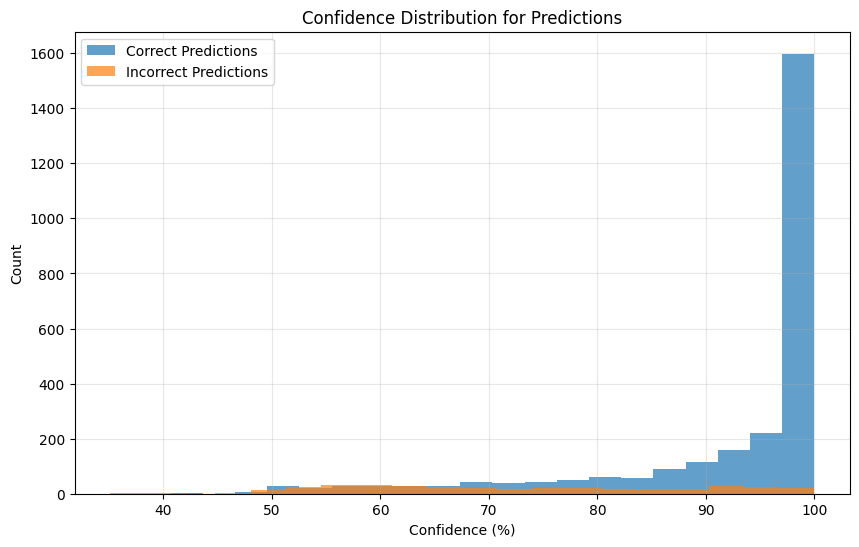

Average confidence for correct predictions: 92.8%
Average confidence for incorrect predictions: 72.5%

Showing 8 misclassified examples:


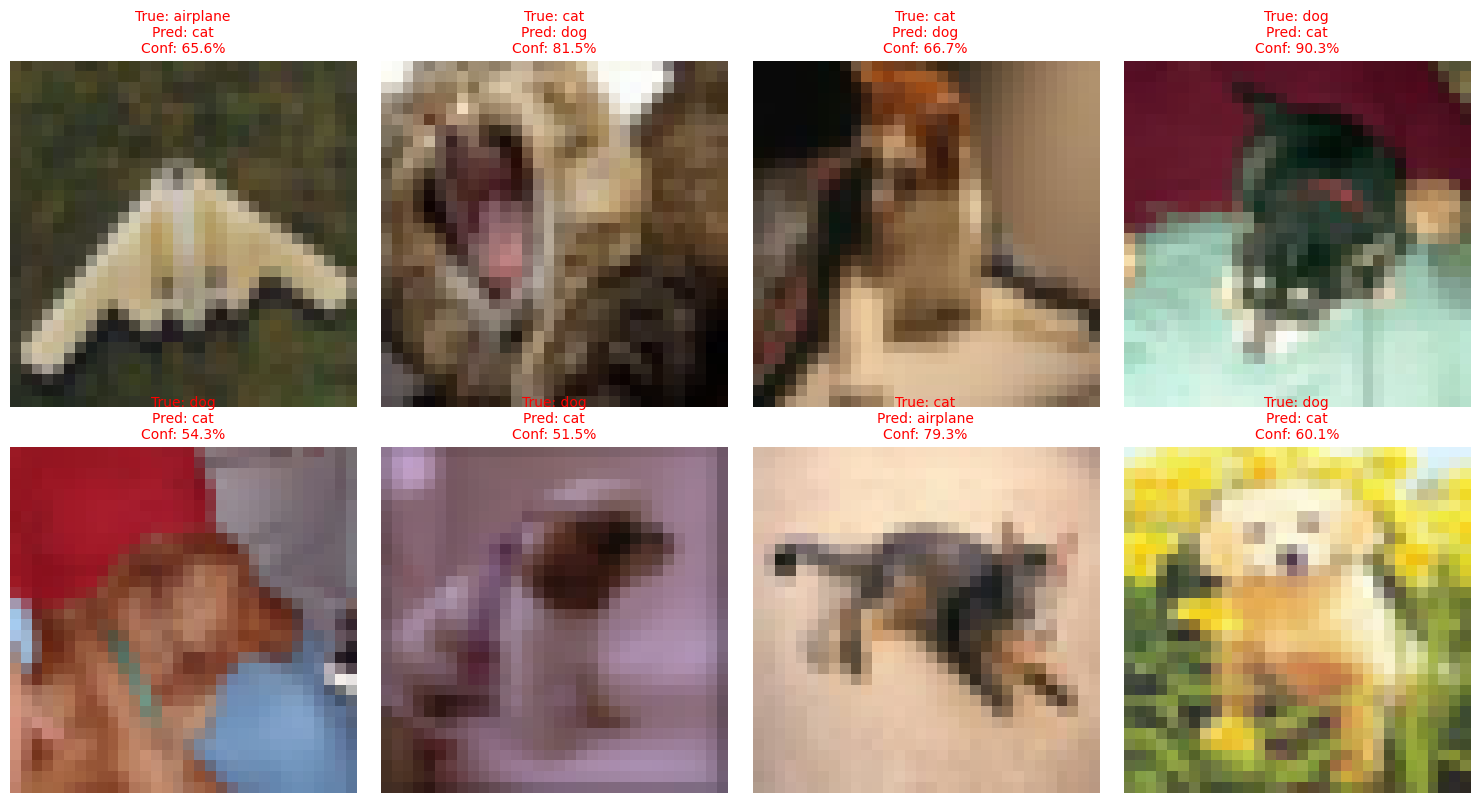

In [51]:
# Test some examples
def test_examples(model, test_loader, device, selected_classes, num_examples=8):
    model.eval()

    # Get a batch of test data
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Convert to numpy for plotting
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()

    # Plot examples
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    for i in range(min(num_examples, 8)):
        row, col = i // 4, i % 4

        # Display image
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[row, col].imshow(img)

        # Set title with prediction info
        true_label = selected_classes[labels[i].item()]
        pred_label = selected_classes[predicted[i].item()]
        confidence = probabilities[i][predicted[i].item()].item() * 100

        color = 'green' if labels[i].item() == predicted[i].item() else 'red'
        axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                                color=color, fontsize=10)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    return images, labels, predicted, probabilities

# Test some examples
print("Testing examples:")
test_images, test_labels, test_preds, test_probs = test_examples(
    model, test_loader, device, selected_classes, num_examples=8
)

# Calculate and display overall test accuracy
def calculate_test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

test_accuracy = calculate_test_accuracy(model, test_loader, device)
print(f"Overall Test Accuracy: {test_accuracy:.2f}%")

# Show confidence distribution for correct vs incorrect predictions
def plot_confidence_distribution(model, test_loader, device):
    model.eval()
    correct_confidences = []
    incorrect_confidences = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(labels)):
                confidence = probabilities[i][predicted[i]].item() * 100
                if predicted[i] == labels[i]:
                    correct_confidences.append(confidence)
                else:
                    incorrect_confidences.append(confidence)

    plt.figure(figsize=(10, 6))
    plt.hist(correct_confidences, alpha=0.7, label='Correct Predictions', bins=20)
    plt.hist(incorrect_confidences, alpha=0.7, label='Incorrect Predictions', bins=20)
    plt.xlabel('Confidence (%)')
    plt.ylabel('Count')
    plt.title('Confidence Distribution for Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Average confidence for correct predictions: {np.mean(correct_confidences):.1f}%")
    print(f"Average confidence for incorrect predictions: {np.mean(incorrect_confidences):.1f}%")

print("\nConfidence distribution:")
plot_confidence_distribution(model, test_loader, device)

# Show misclassified examples
def show_misclassified_examples(model, test_loader, device, selected_classes, num_examples=8):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified.append({
                        'image': inputs[i].cpu(),
                        'true_label': labels[i].item(),
                        'pred_label': predicted[i].item(),
                        'confidence': probabilities[i][predicted[i]].item() * 100
                    })

            if len(misclassified) >= num_examples:
                break

    if misclassified:
        print(f"\nShowing {min(num_examples, len(misclassified))} misclassified examples:")
        fig, axes = plt.subplots(2, 4, figsize=(15, 8))

        for i in range(min(num_examples, len(misclassified))):
            row, col = i // 4, i % 4
            example = misclassified[i]

            # Display image
            img = example['image'].numpy().transpose((1, 2, 0))
            mean = np.array([0.4914, 0.4822, 0.4465])
            std = np.array([0.2023, 0.1994, 0.2010])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            axes[row, col].imshow(img)

            true_label = selected_classes[example['true_label']]
            pred_label = selected_classes[example['pred_label']]
            confidence = example['confidence']

            axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                                    color='red', fontsize=10)
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified examples found!")

# Show misclassified examples
show_misclassified_examples(model, test_loader, device, selected_classes)

In [49]:
# Reproducibility summary
print("Reproducibility Summary:")
print(f"Seed value: {SEED}")
print(f"cuDNN deterministic: {cudnn.deterministic}")
print(f"cuDNN benchmark: {cudnn.benchmark}")
print(f"Total runtime: {training_time/60:.2f} minutes")

# Note on potential sources of nondeterminism
print("\nPotential sources of nondeterminism:")
print("- Data loading with multiple workers (we used num_workers=0)")
print("- Some CUDA operations may have nondeterministic implementations")
print("- Floating point arithmetic precision differences across hardware")

Reproducibility Summary:
Seed value: 42
cuDNN deterministic: True
cuDNN benchmark: False
Total runtime: 2.58 minutes

Potential sources of nondeterminism:
- Data loading with multiple workers (we used num_workers=0)
- Some CUDA operations may have nondeterministic implementations
- Floating point arithmetic precision differences across hardware
